Cofactor swap targets for GRTT


In [1]:
%run 01_Model_CFE.ipynb


c:\Users\Skole\AppData\Local\Programs\Python\Python39\lib\site-packages\nbformat\__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


ADS: frdp_c --> AMOR + ppi_c
CPR1_CYP71AV1: AMOR + h_c + nadph_c + o2_c --> AAOH + h2o_c + nadp_c
ADH1: AAOH + nad_c --> AAld + h_c + nadh_c
ALDH1: AAld + h2o_c + nadp_c --> AA + h_c + nadph_c


In [2]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import cobra
from cobra.io import load_model
iMM904 = load_model('iMM904')

In [4]:
def add_dynamic_bounds(iMM904, y):
    biomass, GRTT = y  # expand the boundary species
    GRTT_max_import = -10 * GRTT / (5 + GRTT)
    iMM904.reactions.GRTT.lower_bound = GRTT_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, GRTT = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with iMM904:
        add_dynamic_bounds(iMM904, y)

        cobra.util.add_lp_feasibility(iMM904)
        feasibility = cobra.util.fix_objective_as_constraint(iMM904)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            iMM904, ['BIOMASS_SC5_notrace', 'GRTT'], ['max', 'max'])
    fluxes = lex_constraints.values
    fluxes *= biomass
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes


In [5]:
dynamic_system.pbar = None

In [6]:

def infeasible_event(t, y):
    with iMM904:

        add_dynamic_bounds(iMM904, y)

        cobra.util.add_lp_feasibility(iMM904)
        feasibility = cobra.util.fix_objective_as_constraint(iMM904)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [7]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

    

t = 15.000: : 106it [10:47,  6.11s/it]


In [8]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 102
     njev: 1
      nlu: 12
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061,
        0.75757576,  0.90909091,  1.06060606,  1.21212121,  1.36363636,
        1.51515152,  1.66666667,  1.81818182,  1.96969697,  2.12121212,
        2.27272727,  2.42424242,  2.57575758,  2.72727273,  2.87878788,
        3.03030303,  3.18181818,  3.33333333,  3.48484848,  3.63636364,
        3.78787879,  3.93939394,  4.09090909,  4.24242424,  4.39393939,
        4.54545455,  4.6969697 ,  4.84848485,  5.        ,  5.15151515,
        5.3030303 ,  5.45454545,  5.60606061,  5.75757576,  5.90909091,
        6.06060606,  6.21212121,  6.36363636,  6.51515152,  6.66666667,
        6.81818182,  6.96969697,  7.12121212,  7.27272727,  7.42424242,
        7.57575758,  7.72727273,  7.87878788,  8.03030303,  8.18181818,
        8.33333333,  8.48484

Text(0, 0.5, 'Frdp_c')

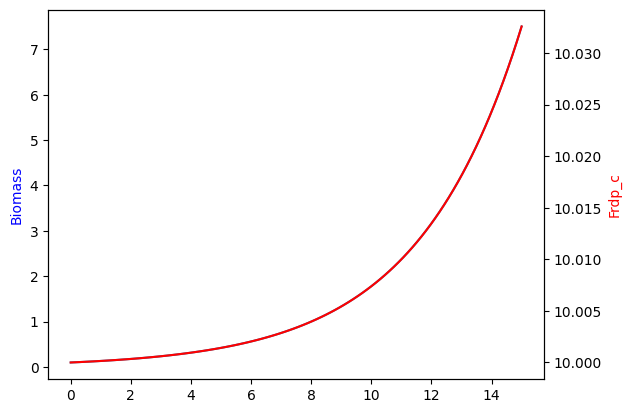

In [9]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Frdp_c', color='r')


Shifting Frdp_c to the right to see that both biomass and Frdp_c are present in the plot

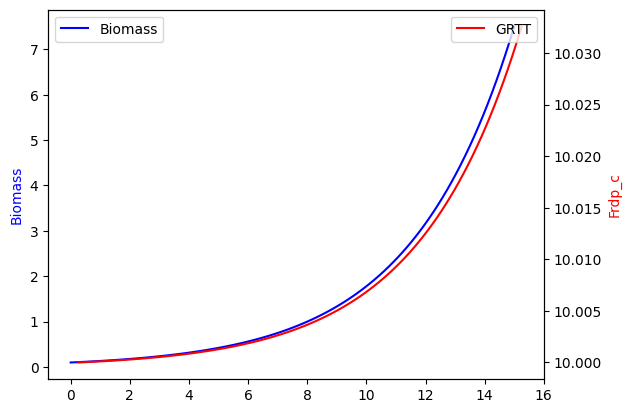

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sol' is defined and contains the data for plotting

ax = plt.subplot(111)

# Plot Biomass
ax.plot(sol.t, sol.y.T[:, 0], label='Biomass', color='b')

# Create a shifted time array for GRTT
shift_value = 0.25  # You can adjust this value
t_shifted = sol.t + shift_value

# Plot GRTT with shifted time
ax2 = plt.twinx(ax)
ax2.plot(t_shifted, sol.y.T[:, 1], label='GRTT', color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Frdp_c', color='r')

# Show legend for both plots
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()
